# Smoothing 
接受一段时间信号后，最新的测量和此前的测量差别很大（超出信号包络）

可能有三种情况：
1. 状态基本稳定，此前的结果噪声大，没有跟踪到最新测量的前置变化
2. 最新的测量源于状态突然的变化
3. 最新的测量噪声过大


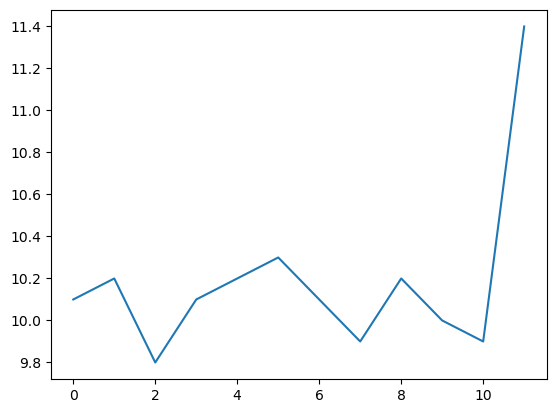

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
data = [10.1, 10.2, 9.8, 10.1, 10.2, 10.3, 10.1, 9.9, 10.2, 10.0, 9.9, 11.4]
plt.plot(data)

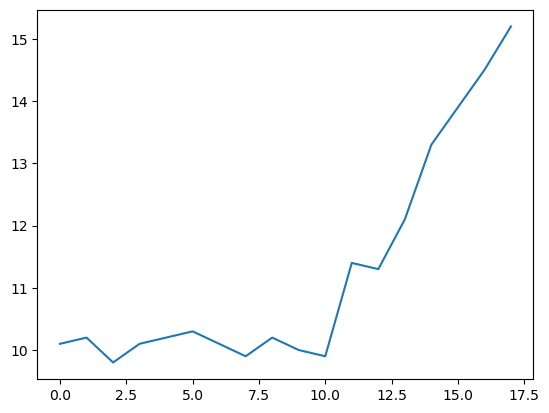

In [40]:
data2 = [11.3, 12.1, 13.3, 13.9, 14.5, 15.2]
plt.plot(data + data2)

此时我们陆续收到data2，我们可以相信是状态发生了较大变化


但如果我们在受到data时只使用Kalman滤波可能会把最新的测量当成噪声去除

这时我们会需要一个Smoother,他会把k,k+1,k+2的数据同时考虑进来，而Kalman Smoother可以保证其估计的最优性


## RTS Smoother
批处理平滑器会在所有数据收集完成后进行统一处理，zupt就是一种典型的批处理平滑器

固定间隔平滑会在收集到固定长度的新数据后对数据进行一次平滑

RTS（Rauch, Tung, and Striebel） Smoother使用简单且计算效率高，是一种常见的批处理平滑器





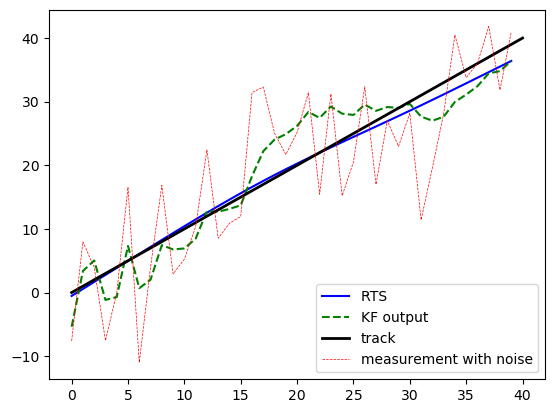

In [41]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
def plot_rts(noise, Q=0.001, show_velocity=False):
    random.seed(123)
    fk = KalmanFilter(dim_x=2, dim_z=1)

    fk.x = np.array([0., 1.])      # initial state (location and velocity)

    fk.F = np.array([[1., 1.],
                     [0., 1.]])    # state transition matrix

    fk.H = np.array([[1., 0.]])    # Measurement function
    fk.P = 10.                     # covariance matrix
    fk.R = noise                   # state uncertainty
    fk.Q = Q                       # process uncertainty

    # create noisy data
    zs = np.asarray([t + random.randn()*noise for t in range (40)])

    # filter data with Kalman filter, than run smoother on it
    mu, cov, _, _ = fk.batch_filter(zs)
    M,P,C,_ = fk.rts_smoother(mu, cov)

    # plot data
    if show_velocity:
        index = 1
        print('gu')
    else:
        index = 0
    plt.plot(M[:, index], c='b', label='RTS')
    plt.plot(mu[:, index], c='g', linestyle='--', label='KF output')
    if not show_velocity:
        plt.plot([0, len(zs)], [0, len(zs)], 'k', linewidth=2, label='track')
        plt.plot(zs,'r', linewidth=.5, label="measurement with noise", linestyle='--') 
    plt.legend(loc=4)
    plt.show()
    
plot_rts(7.)


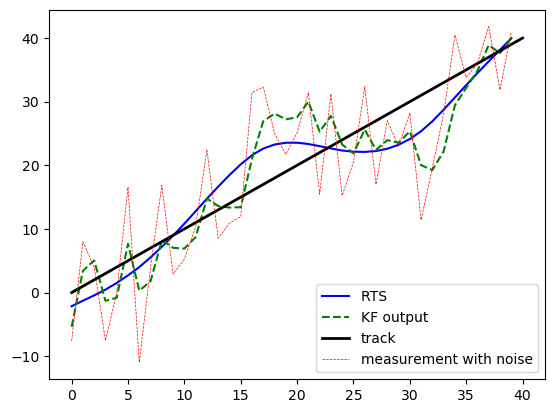

In [42]:
plot_rts(noise=7., Q=.1)

当我们在跟踪一个过程噪声较大的信号时，平滑器会降低对于传递函数计算出的期望的信赖


当我们无法使用所有信号进行平滑，就需要使用固定间隔的滑窗来操作

standard deviation fixed lag: 2.6162441739217632
standard deviation kalman: 3.5622192846090286


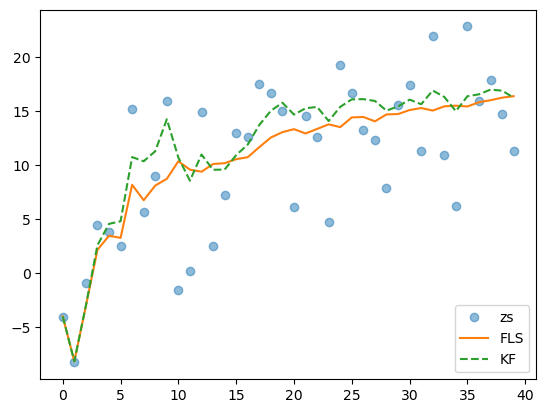

In [43]:
from filterpy.kalman import FixedLagSmoother, KalmanFilter
import numpy.random as random

fls = FixedLagSmoother(dim_x=2, dim_z=1, N=8)

fls.x = np.array([0., .5])
fls.F = np.array([[1.,1.],
                  [0.,1.]])

fls.H = np.array([[1.,0.]])
fls.P *= 200
fls.R *= 5.
fls.Q *= 0.001

kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([0., .5])
kf.F = np.array([[1.,1.],
                 [0.,1.]])
kf.H = np.array([[1.,0.]])
kf.P *= 200
kf.R *= 5.
kf.Q *= 0.001

N = 4 # size of lag

nom =  np.array([t/2. for t in range (0, 40)])
zs = np.array([t + random.randn()*5.1 for t in nom])

for z in zs:
    fls.smooth(z)
    
kf_x, _, _, _ = kf.batch_filter(zs)
x_smooth = np.array(fls.xSmooth)[:, 0]


fls_res = abs(x_smooth - nom) #residual of fls
kf_res = abs(kf_x[:, 0] - nom) #residual of kf

plt.plot(zs,'o', alpha=0.5, marker='o', label='zs')
plt.plot(x_smooth, label='FLS')
plt.plot(kf_x[:, 0], label='KF', ls='--')
plt.legend(loc=4)

print('standard deviation fixed lag:', np.mean(fls_res))
print('standard deviation kalman:', np.mean(kf_res))

FilterPy的FixedLagSmoother会对$x_{k-N+1}$到$x_{k}$进行Kalman Filter从而得到$x_k$, 再运行Smoother得到$x_{k}$之前的数据的平滑值
